# Predicting diabetes patients near term re-admission rate

In [2]:
#imports
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sb
from sklearn.model_selection import train_test_split

**We aim to see if using patient data we can predict readmission rates. Our goal in this project is classification of patients into those that will be readmitted and those that will not be**

## Set Up
### Import data

In [5]:
df = pd.read_csv("diabetic_data.csv")

In [6]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


## Data exploration and transformation

In [8]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

**We currently have 50 features. Our Data is structured and split between numerical Data and 
categorical data such as race and gender**

#### Data transformation of the "readmitted" attribute
We want to predict whether a patient is more likely to be admitted.  The readmited column of the data currently shows if they were not readmitted (keyword: "NO"), if they were readmited for less that 30 days (keyword: "<30") or if they are readmitted for more than 30 days (keyword: ">30").

We will be making a new column called readmitted_binary so it contains a binary numerical value:
- 1 if the patient was readmitted within 30 days
- 0 If they were not

In [11]:
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

In [12]:
# We make sure we only have 1 or 0 in readmitted column
unique_vals = df['readmitted_binary'].unique()

print("Unique values in 'readmitted_binary' column:")
print(unique_vals)

Unique values in 'readmitted_binary' column:
[0 1]


Our data appears to be very skewed in one direction. We will have to address this later before training our model

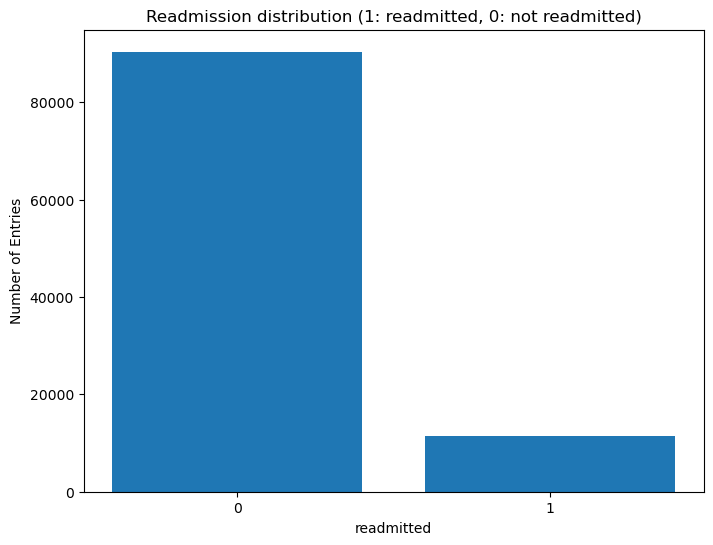

In [14]:
# Step 1: Count the occurrences of each unique value in the 'Category' column
category_counts = df['readmitted_binary'].value_counts()

# Step 2: Plot the results using seaborn barplot
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values)

# Step 3: Only show ticks for categories with a count > 0
plt.xticks(ticks=range(len(category_counts)), labels=category_counts.index)

# Add labels and title
plt.xlabel('readmitted')
plt.ylabel('Number of Entries')
plt.title('Readmission distribution (1: readmitted, 0: not readmitted)')

# Show the plot
plt.show()

Because we counted only shorterm readmissions as readmitted we see there is an imbalance in the quantity of readmitted and non readmitted

### Explore Demographics some demographics and features

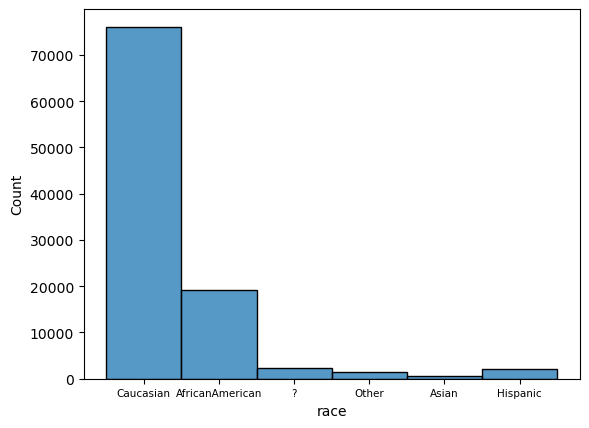

In [16]:
sb.histplot(df['race'])
plt.xticks(fontsize=7.5)
plt.show()

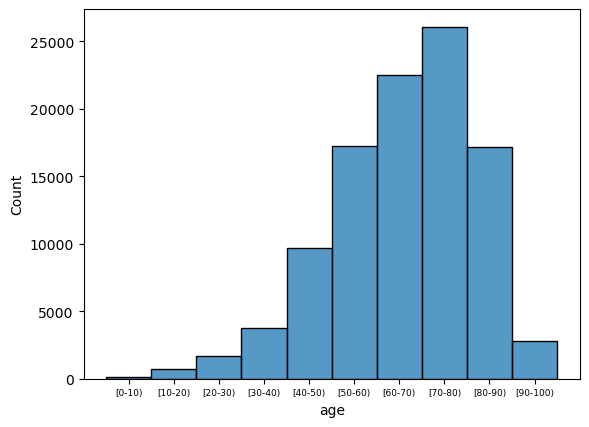

In [17]:
sb.histplot(df['age'])
plt.xticks(fontsize=6.5)
plt.show()

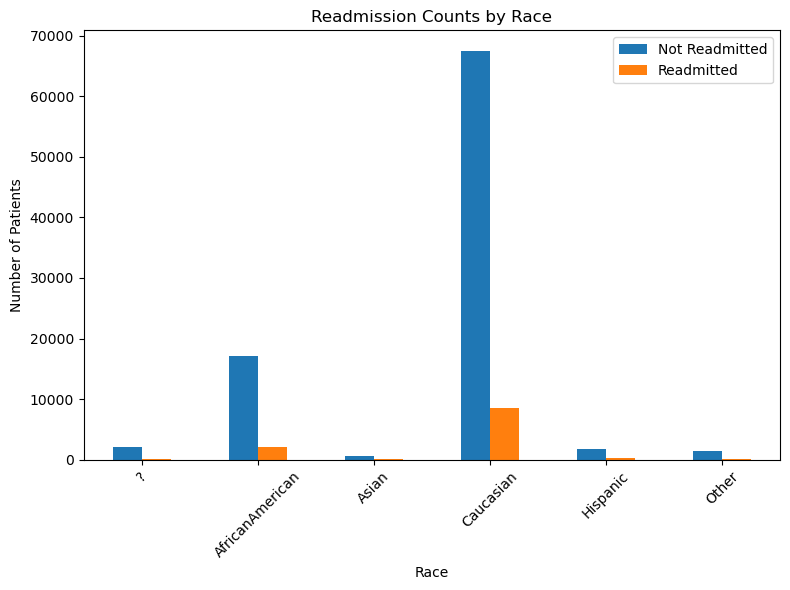

In [18]:
race_readmitted_counts = df.groupby(['race', 'readmitted_binary']).size().unstack(fill_value=0)

race_readmitted_counts.plot(kind='bar', stacked=False, figsize=(8, 6))

plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.title('Readmission Counts by Race')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(['Not Readmitted', 'Readmitted'])
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

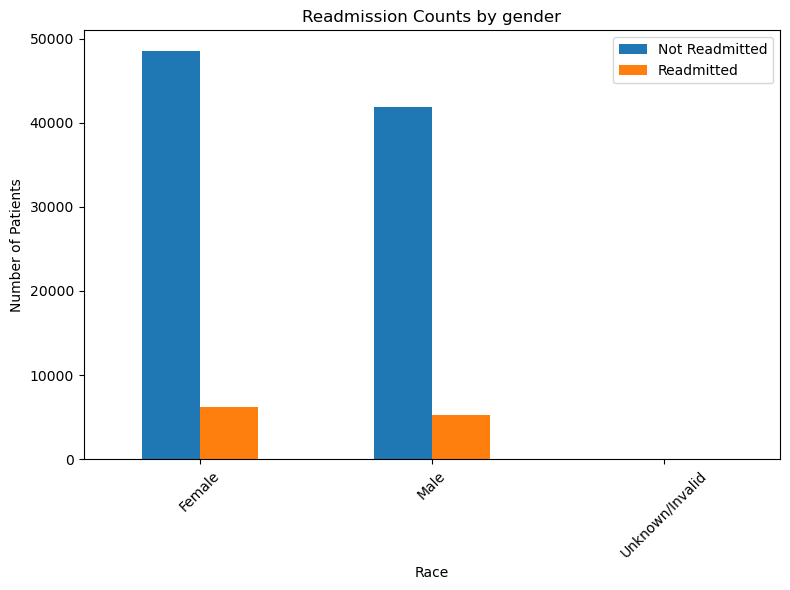

In [19]:
race_readmitted_counts = df.groupby(['gender', 'readmitted_binary']).size().unstack(fill_value=0)

race_readmitted_counts.plot(kind='bar', stacked=False, figsize=(8, 6))

plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.title('Readmission Counts by gender')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(['Not Readmitted', 'Readmitted'])
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Time spent in hospital vs readmission

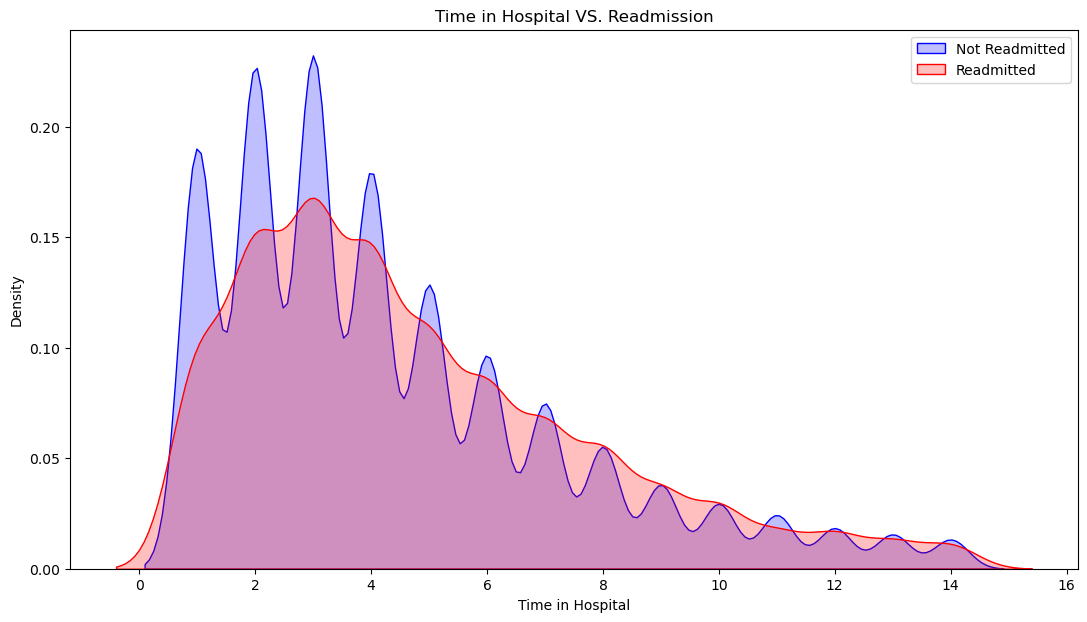

In [21]:
fig = plt.figure(figsize=(13,7),)
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 0),'time_in_hospital'] , color='b',fill=True,label='Not Readmitted')
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 1),'time_in_hospital'] , color='r',fill=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Density')
plt.title('Time in Hospital VS. Readmission')
plt.legend()

There is not a very clear distinction between likelyhood to be readmitted and not readmitted based on time spent in the hospital. The non readmitted has more peaks and valleys but still ends up following the same general trend as the readmitted

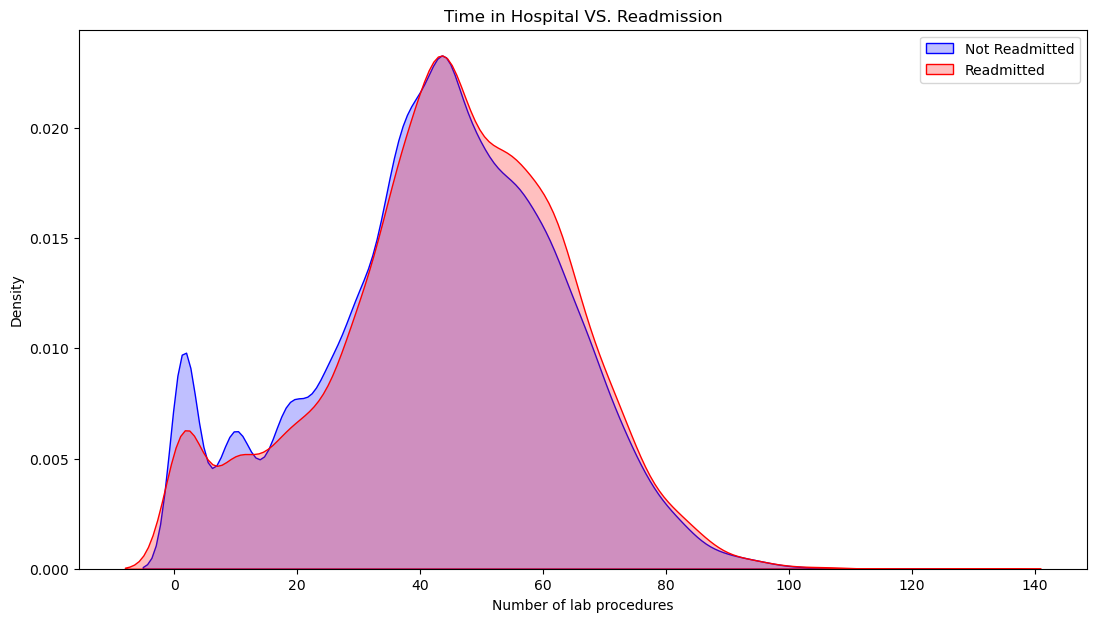

In [213]:
fig = plt.figure(figsize=(13,7),)
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 0),'num_lab_procedures'] , color='b',fill=True,label='Not Readmitted')
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 1),'num_lab_procedures'] , color='r',fill=True, label='Readmitted')
ax.set(xlabel='Number of lab procedures', ylabel='Density')
plt.title('Time in Hospital VS. Readmission')
plt.legend()

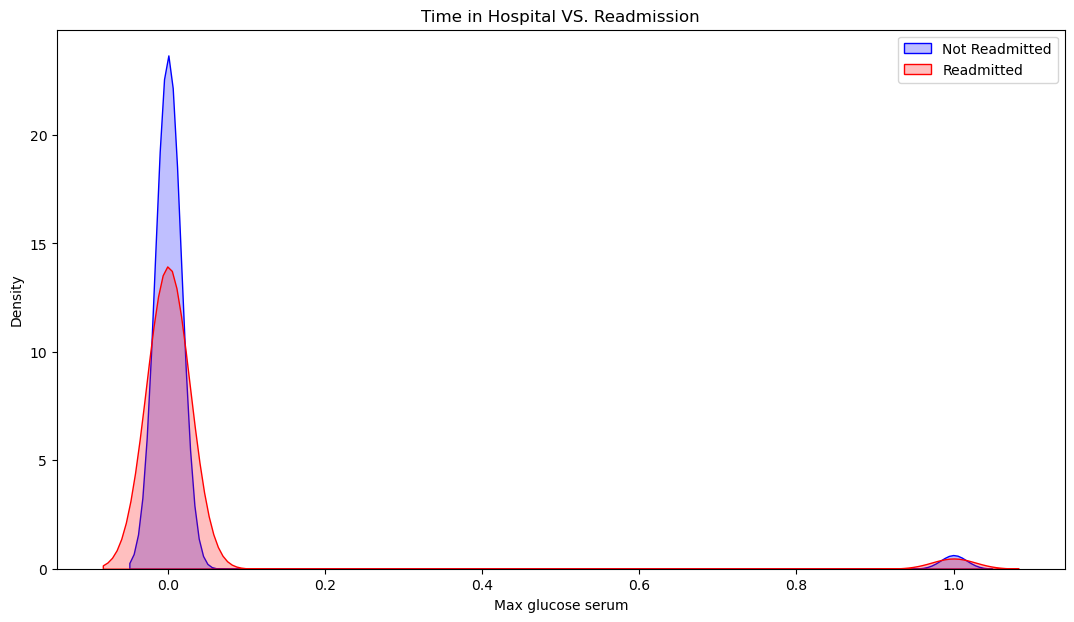

In [215]:

fig = plt.figure(figsize=(13,7),)
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 0),'max_glu_serum'] , color='b',fill=True,label='Not Readmitted')
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 1),'max_glu_serum'] , color='r',fill=True, label='Readmitted')
ax.set(xlabel='Max glucose serum', ylabel='Density')
plt.title('Time in Hospital VS. Readmission')
plt.legend()

## Data cleaning and Feature generation

Drop all unnecessary columns

In [25]:
# Drop columns with too many missing values
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
# Remove data with all of the same values
df = df.drop(['citoglipton', 'examide'], axis = 1)

Clean Data of unknown values

In [27]:
#Checking for missing values in the data
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())
            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

race 2273
gender 0
age 0
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


In [28]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

In [29]:
#Checking for missing values in the data
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())
            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


Change string values in data set to integers

In [31]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

pd.set_option('future.no_silent_downcasting', True)
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)
    
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

Changing age category to mid point values and scaling them down

In [33]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()


age
8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: count, dtype: int64

Change race into integer value

In [35]:
unique_races = df['race'].unique()

# Print the unique values
print(f"Unique races {unique_races}")
race_col = 'race'
df[race_col] = df[race_col].replace('Caucasian', 1)
df[race_col] = df[race_col].replace('Other', 2)
df[race_col] = df[race_col].replace('AfricanAmerican', 3)
df[race_col] = df[race_col].replace('Hispanic', 4)
df[race_col] = df[race_col].replace('Asian', 5)

col_to_change_to_int = 'race'

df[col_to_change_to_int] = pd.to_numeric(df[col_to_change_to_int], errors='coerce')
has_nan = df[col_to_change_to_int].isna().any()
print(has_nan)
df[col_to_change_to_int] = df[col_to_change_to_int].fillna(0).astype(int)  # Replace NaN with 0 and convert to int

Unique races ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
False


In [36]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

Change test values to integers

In [38]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    df[col] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

In [39]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide           

Change all features to be used for our model to int

In [41]:
cols_to_change_to_int = ['age', 'gender', 'A1Cresult', 'diabetesMed', 'change', 'max_glu_serum' ]
for col_to_change_to_int in cols_to_change_to_int:    
    df[col_to_change_to_int] = pd.to_numeric(df[col_to_change_to_int], errors='coerce')
    has_nan = df[col_to_change_to_int].isna().any()
    print(has_nan)
    df[col_to_change_to_int] = df[col_to_change_to_int].fillna(0).astype(int)  # Replace NaN with 0 and convert to int

False
False
True
False
False
True


In [42]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                       int32
age                          int32
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum                int32
A1Cresult                    int32
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide           

In [153]:
### Data Visualization of cleaned Data
columns_to_drop = ['readmitted','encounter_id', 'patient_nbr','weight','payer_code','medical_specialty','citoglipton', 'examide', "diag_1", "diag_2", "diag_3",'level1_diag1', 'readmitted']
feature_set_int = [item for item in feature_set_int if item not in columns_to_drop]
df_clean = df[feature_set_int]

#### Looking at correlation of some features we want to select for our model
No feature correlation was too high in the features we looked at. The highest was number of meds and time in hospital but even then it wasn't too high where we would exclude one of them.

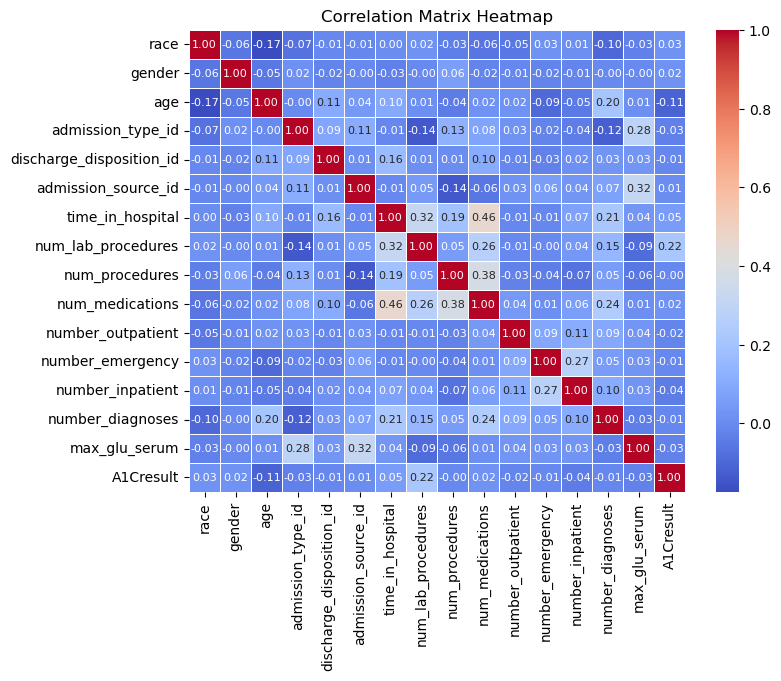

In [195]:
df_to_corr = df[[ 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult']]

# Calculate the correlation matrix
corr_matrix = df_to_corr .corr()
# Create a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,annot_kws={'size': 8})

# Add a title
plt.title("Correlation Matrix Heatmap")
plt.show()

In [175]:
df.head(10).T

,1,2,3,4,5,6,7,8,9,10
encounter_id,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236
patient_nbr,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032
race,1,3,1,1,1,1,1,1,1,3
gender,0,0,1,1,1,1,1,0,0,0
age,2,3,4,5,6,7,8,9,10,5
admission_type_id,1,1,1,1,2,3,1,2,3,1
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1
admission_source_id,7,7,7,7,2,2,7,4,4,7
time_in_hospital,3,2,2,1,3,4,5,13,12,9
num_lab_procedures,59,11,44,51,31,70,73,68,33,47


## Data Modelling

We tried the decision tree model and random forest model. The random forest had better results in terms of accuracy and precision as can be seen below. We wanted to improve our precision so we tried the random forest again but using SMOTE for oversampling and then using undersampling methods as well to  fix the issue of our biased data but both these methods did not yield better results. We also used PCA (Principal Component Analysis) for dimentionality reduction and then used SMOTE as we hypothesized that the high dimentionality of our data might be an issue but this did not yield better results. 

In [44]:
# Get all column names
column_names = df.columns
# Convert to list if you want it as a regular list
feature_set_int = column_names.tolist()
print(feature_set_int)

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'readmitted_binary']


I dropped the id numbers and also the diagnoses data. The diagnoses data was dropped because it was notin a format the model would understand


In [199]:
columns_to_drop = ['readmitted_binary','readmitted','encounter_id', 'patient_nbr','weight','payer_code','medical_specialty','citoglipton', 'examide', "diag_1", "diag_2", "diag_3",'level1_diag1', 'readmitted']
feature_set_int = [item for item in feature_set_int if item not in columns_to_drop]
X = df[feature_set_int]
Y = df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

### Decision tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [49]:
y_prd = dtree.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


Predict,0,1,All
Actual,,,
0,15649,1392,17041
1,1943,306,2249
All,17592,1698,19290


In [50]:
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

accuracy_rm = accuracy_score(y_test, y_prd)
precision_rm = precision_score(y_test,y_prd)
recall_rm = recall_score(y_test, y_prd)
f1_rm = f1_score(y_test, y_prd)

Accuracy is 0.8271
Precision is 0.1802
Recall is 0.1361
F1 is 0.1551


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [201]:
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [203]:
y_prd = rm.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


Predict,0,1,All
Actual,,,
0,16996,45,17041
1,2217,32,2249
All,19213,77,19290


In [207]:
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

accuracy_rm = accuracy_score(y_test, y_prd)
precision_rm = precision_score(y_test,y_prd)
recall_rm = recall_score(y_test, y_prd)
f1_rm = f1_score(y_test, y_prd)

Accuracy is 0.8827
Precision is 0.4156
Recall is 0.0142
F1 is 0.0275


In [209]:
# Get feature importances
importances = rm.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance (highest first)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

                     Feature  Importance
7         num_lab_procedures    0.168243
9            num_medications    0.141390
12          number_inpatient    0.087443
6           time_in_hospital    0.086666
2                        age    0.072283
4   discharge_disposition_id    0.069145
8             num_procedures    0.060959
13          number_diagnoses    0.056680
3          admission_type_id    0.042103
10         number_outpatient    0.039454
5        admission_source_id    0.039198
0                       race    0.034689
11          number_emergency    0.034122
1                     gender    0.021004
37                    change    0.016587
15                 A1Cresult    0.011810
38               diabetesMed    0.011723
14             max_glu_serum    0.006502
17               repaglinide    0.000000
18               nateglinide    0.000000
36    metformin-pioglitazone    0.000000
35   metformin-rosiglitazone    0.000000
34  glimepiride-pioglitazone    0.000000
33       glipizi

It seems like a lot of the features we had ended up having no relevance to the final classifier. For now we will move on to modelling with all the features and last we shall try modelling with just the top 10 most important features

### Using SMOTE (Synthetic Minority Over-sampling Technique)  and undersampling to see if we find better results

In [93]:
!pip install imblearn

In [95]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [100]:
#Apply Smote
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_smote)))

rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)
y_prd = rm.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
print("\nWithout SMOTE")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))
      
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)
rm_smote = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)

rm_smote.fit(X_train_smote, y_train_smote)
y_prd = rm_smote.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
print("\nWith SMOTE")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


Original dataset shape Counter({0: 68339, 1: 8817})
New dataset shape Counter({0: 68339, 1: 68339})

Without SMOTE
Accuracy is 0.8829
Precision is 0.4286
Recall is 0.0120
F1 is 0.0234

With SMOTE
Accuracy is 0.7411
Precision is 0.1521
Recall is 0.2668
F1 is 0.1937


Predict,0,1,All
Actual,,,
0,13696,3345,17041
1,1649,600,2249
All,15345,3945,19290


In [106]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()

In [108]:
#Apply Undersampler
print('Original dataset shape {}'.format(Counter(y_train)))
undersample = RandomUnderSampler()
X_train_undr, y_train_undr = undersample.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_undr)))

rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)
y_prd = rm.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
print("\nWithout undersampling")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))
      
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)
rm_undr = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)

rm_undr.fit(X_train_undr, y_train_undr)
y_prd = rm_undr.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
print("\nWith undersampling")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)

Original dataset shape Counter({0: 68339, 1: 8817})
New dataset shape Counter({0: 8817, 1: 8817})

Without undersampling
Accuracy is 0.8823
Precision is 0.3704
Recall is 0.0133
F1 is 0.0258

With undersampling
Accuracy is 0.5895
Precision is 0.1598
Recall is 0.5923
F1 is 0.2517


Predict,0,1,All
Actual,,,
0,10040,7001,17041
1,917,1332,2249
All,10957,8333,19290


### Try to get better results with feature elimination

In [218]:
from sklearn.decomposition import PCA

In [222]:
pca = PCA(n_components=18)  # Reduce to 10 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
rm = RandomForestClassifier(random_state=42)
rm.fit(X_train_pca, y_train)



RandomForestClassifier(random_state=42)

In [224]:
y_prd = rm.predict(X_test_pca)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,17018,23,17041
1,2221,28,2249
All,19239,51,19290


In [226]:
print("\nWith undersampling")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))


With undersampling
Accuracy is 0.8837
Precision is 0.5490
Recall is 0.0124
F1 is 0.0243


Feature reduction seems to have led to an improvement in precison!

In [228]:
X_test_pca.shape

(19290, 18)

In [230]:
X_train_smote, y_train_smote = sm.fit_resample(X_train_pca, y_train)

In [232]:
rm_smote = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)

rm_smote.fit(X_train_smote, y_train_smote)
y_prd = rm_smote.predict(X_test_pca)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
print("\nWith SMOTE")
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


With SMOTE
Accuracy is 0.8371
Precision is 0.2040
Recall is 0.1369
F1 is 0.1639


Predict,0,1,All
Actual,,,
0,15839,1202,17041
1,1941,308,2249
All,17780,1510,19290


Oversampling did not give us better results with decreased features

## Conclusion

We think that there is potential in being able to predict readmission using data but more relevant features would be needed such as weight. Weight can be a huge factor in deciding whether or not a patient will need extra care but over 90% of weight calues were missing. The data was also to biased to one side as we were grouping only patients who were readmitted before 30 days as being "readmitted". We did however perform an analysis on patients grouping readmissions in a broader way. We ran an analysis grouping even patients readmitted after 30 days into the readmitted bucket and that gave a better ratio between readmitted and not readmitted of about 1 to 0.8. We will submit the code for this analysis aswell. Broading the readmission category increased the precision to ~60% but reduced the accuracy to about ~60% which is still not ideal.

We used 2 different models for classfying our data. The decision 3 and the random forest. The random forest gave us the best results and even better results when we removed the features that were irrelivant. The acccuracy was high at 88% but even our best result for rpecision was just ~54%. In the future we aim to increase precision. We tried correcting the bias of the data with less features but the oversampling did not help the accuracy or precison. 

Over all we conclude that more relevant features should be present in this data set and the data quality could also be greatly improved by collecting more data  from patients who were readmitted in the short term as there was an over representation of patients who were not readmitted at all or were readmitted in the long term.